# Challenge Summary

Can you predict local epidemics of dengue fever?

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

In recent years dengue fever has been spreading. Historically, the disease has been most prevalent in Southeast Asia and the Pacific islands. These days many of the nearly half billion cases per year are occurring in Latin America:

Using environmental data collected by various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce—can you predict the number of dengue fever cases reported each week in San Juan, Puerto Rico and Iquitos, Peru?


# Team Information
Name: Team Fondue
Members:
- Anthony Xavier Poh Tianci (E0406854)
- Tan Jia Le Damien (E0310355)


# Imports

In [137]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings("ignore")


# Data Exploration

In [138]:
train_features = pd.read_csv('./dengue_features_train.csv', index_col=[0,1,2])
train_labels = pd.read_csv('./dengue_labels_train.csv', index_col=[0,1,2])
test_features = pd.read_csv('./dengue_features_test.csv', index_col=[0,1,2])
                    

In [139]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']


In [140]:
sj_train_features.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   

                 reanalysis_precip_amt_kg_per_m2  \
year weekofyear                                    
1990 18                                    32.00   
     19                                    17.94   
     20                                    26.10   
     21                                    13.90   
     22                                    12.20   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
year weeko

In [141]:
sj_train_labels.head()

total_cases
year weekofyear             
1990 18                    4
     19                    5
     20                    4
     21                    3
     22                    6

In [142]:
sj_train_with_info = sj_train_features.merge(right=sj_train_labels, left_on=['year','weekofyear'], right_on=['year','weekofyear'], how='inner')
sj_train_with_info = sj_train_with_info.drop(columns=['week_start_date'])
sj_train_with_info = sj_train_with_info.dropna()

In [143]:
multlin = smf.ols(formula='total_cases ~'+ ' + '.join(sj_train_with_info.columns), data=sj_train_with_info).fit()
print(multlin.summary())

                            OLS Regression Results                            
Dep. Variable:            total_cases   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.315e+25
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:53:19   Log-Likelihood:                 16522.
No. Observations:                 727   AIC:                        -3.300e+04
Df Residuals:                     706   BIC:                        -3.291e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [144]:
variables = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'total_cases']

num_data = sj_train_with_info[variables]
num_data.head()


ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
year weekofyear                                                                 
1990 18          0.122600  0.103725  0.198483  0.177617                 12.42   
     19          0.169900  0.142175  0.162357  0.155486                 22.82   
     20          0.032250  0.172967  0.157200  0.170843                 34.54   
     21          0.128633  0.245067  0.227557  0.235886                 15.36   
     22          0.196200  0.262200  0.251200  0.247340                  7.52   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
year weekofyear                                                 
1990 18                     297.572857             297.742857   
     19                     298.211429             298.442857   
     20                     298.781429             298.878571   
     21                     298.987143             299.228571   
     22                     299.518571             299.664286   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
year weekofyear                                                           
1990 18                           292.414286                      299.8   
     19                           293.951429                      300.9   
     20                           295.434286                      300.5   
     21                           295.310000                      301.4   
     22                           295.821429                      301.9   

                 reanalysis_min_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              295.9  ...   
     19                              296.4  ...   
     20                              297.3  ...   
     21                              297.0  ...   
     22                              297.5  ...   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   

                 reanalysis_sat_precip_amt_mm  \
year weekofyear                                 
1990 18                                 12.42   
     19                                 22.82   
     20                                 34.54   
     21                                 15.36   
     22                                  7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857           2.628571   
     19                                      15.372857           2.371429   
     20                                      16.848571           2.300000   
     21                                      16.672857           2.428571   
     22                                      17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
1990 18                   25.442857                 6.900000   
     19                   26.714286                 6.371429   
     20                   26.714286                 6.485714   
     21                   27.471429                 6.771429   
     22                   28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
year weekofyear                                                              
1990 18                        29.4                20.0               16.0   
     19                        31.7                22.2                8.6   
     20                        32.2                22.8          

<AxesSubplot:>

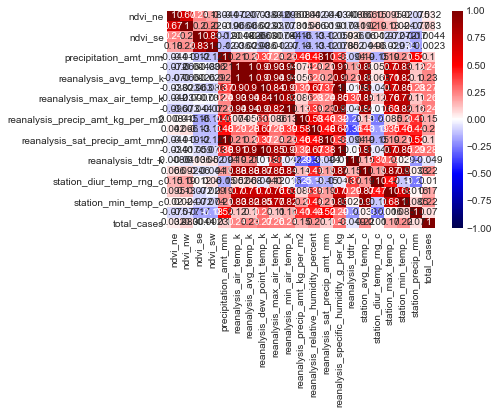

In [145]:
corr = num_data.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, cmap='seismic',annot=True, vmin=-1, vmax=1)